In [ ]:
# """Complete CNN-LR-SVM pipeline using HNVec/SamacharVec embeddings """

In this implementation:


---


***FIRST LAYER***

***CNN Model:*** Train the CNN model using sequences and extract its features.
*   *Input:* Tokenizing and padding the sequences for CNN
*   *CNN Features:* The output of the dense layer (or the global max-pooling layer) is considered the extracted feature representation of the input text.


---
***SECOND LAYER***

**Combine HNVec/SamacharVec Embeddings with CNN features**

***SVM Model(RBF Kernel):*** Train the SVM model using combined HNVec/SamacharVec Embeddings features and cnn features.
*   *Input:* Combined features of HNVec/SamacharVec Embeddings and CNN.
*   *SVM features:* Features Extracted using **predict_proba**

***Logistic Regression Model:*** Train the LR model using combined HNVec/SamacharVec Embeddings and cnn features.
*   *Input:* Combined features of HNVec/SamacharVec Embeddings and CNN.
*   *LR features:* Features Extracted using **predict_proba**


---

***THIRD(FINAL) LAYER***

**Then Combine SVM features with LR features.**

***Final Model- SVM Model(RBF Kernel):*** Train the final SVM model using Combined features of SVM and LR.

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

# TensorFlow/Keras imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [ ]:
# Load datasets
class_0 = pd.read_csv('/content/drive/MyDrive/csv/accident.csv', index_col=[0])
class_1 = pd.read_csv('/content/drive/MyDrive/csv/business.csv', index_col=[0])
# class_2 = pd.read_csv('/content/drive/MyDrive/csv/crime.csv', index_col=[0])
class_3 = pd.read_csv('/content/drive/MyDrive/csv/entertainment.csv', index_col=[0])
# class_4 = pd.read_csv('/content/drive/MyDrive/csv/general.csv', index_col=[0])
# class_5 = pd.read_csv('/content/drive/MyDrive/csv/healthcare.csv', index_col=[0])
class_6 = pd.read_csv('/content/drive/MyDrive/csv/political.csv', index_col=[0])
# class_7 = pd.read_csv('/content/drive/MyDrive/csv/science-and-tech.csv', index_col=[0])
class_8 = pd.read_csv('/content/drive/MyDrive/csv/sports.csv', index_col=[0])
# class_9 = pd.read_csv('/content/drive/MyDrive/csv/war-protest.csv', index_col=[0])

In [ ]:
# Add labels to each class
class_0['label'] = 0
class_1['label'] = 1
# class_2['label'] = 2
class_3['label'] = 3
# class_4['label'] = 4
# class_5['label'] = 5
class_6['label'] = 6
# class_7['label'] = 7
class_8['label'] = 8
# class_9['label'] = 9

In [ ]:
# Combine all datasets
# news = pd.concat([class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8, class_9])
news = pd.concat([class_0, class_1, class_3, class_6, class_8])

# Define features and labels
X_Before = news['news_articles']  # raw texts
y = news['label']

In [ ]:
# Custom stop words and tokenizer
stop_words = set(['।','',' ',' ','!','! ','!  ','! !','! ! ','! ! !','?','अरे', 'चैनल्स', 'ये','ही','तुमसे','बार','आप','तुम्हारे','तु','रहा','कुछ','कभी',
              'एक','तुम','होता','नहीं','कितनी','पर','तू','हो','है','क्यों','एप','कर','काम','रहे','बातें','लग','आता','ये चैनल्स','करनी','अपना','पैक्स','चीज़','क्या','अरे ये','करा','मैं',
              'अत','अपना','अपनी','अपने','अभी','अंदर','आदि','आप','इत्यादि','इन','इनका','इन्हीं','इन्हें','इन्हों','इस','इसका','इसकी','इसके','इसमें',
              'इसी','इसे','उन','उनका','उनकी','उनके','उनको','उन्हीं','उन्हें','उन्हों','उस','उसके','उसी','उसे','एक','एवं','एस','ऐसे','और','कई',
              'कर','करता','करते','करना','करने','करें','कहते','कहा','का','काफ़ी','कि','कितना','किन्हें','किन्हों','किया','किर','किस','किसी','किसे','की',
              'कुछ','कुल','के','को','कोई','कौन','कौन','बही','बहुत','बाद','बाला','बिलकुल','भी','भीतर','मगर','मानो','मे','में','यदि','यह','यहाँ','यही',
              'या','यिह','ये','रखें','रहा','रहे','ऱ्वासा','लिए','लिये','लेकिन','व','वग़ैरह','वर्ग','वह','वहाँ','वहीं','वाले','वुह','वे','सकता','सकते','सबसे',
              'सभी','साथ','साबुत','साभ','सारा','से','सो','संग','ही','हुआ','हुई','हुए','है','हैं','हो','होता','होती','होते','होना','होने'])
def preprocess(text):
    # Convert to lowercase
    # text = text.lower()

    # # Remove single quote, double quote, full stop
    text = re.sub(r"[.'\"]", "", text)
    # Remove English characters, special characters, and new lines
    text = re.sub(r'[^\u0900-\u097F\s]', '', text)  # Keeping only Hindi characters and spaces
    #remove numbers
    text= re.sub(r"\d+", "", text)
    text = re.sub(r'http[s]?://\S+', '', text)  # Remove hyperlinks
    text = re.sub(r'[\x00-\x08\x0B\x0C\x0E-\x1F]', '', text)  # Remove non-printable characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and new lines
    # Tokenize (split into words)
    words = text.split()

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    return filtered_words  # Return as a list of tokens

# Process the entire dataset
X = [' '.join(preprocess(text)) for text in X_Before]

In [ ]:
total_length_import = sum(len(text.split()) for text in X_Before)
print(f"Total Length at Import: {total_length_import}")

Total Length at Import: 801148


In [ ]:
total_length_before = sum(len(text.split()) for text in X)
print(f"Total Length After Pre-Processing: {total_length_before}")

Total Length After Pre-Processing: 485968


In [ ]:
reduction_import_to_tokenized = ((total_length_import - total_length_before) / total_length_import) * 100
# reduction_tokenized_to_filtered = ((total_length_before - total_length_after) / total_length_before) * 100
# reduction_import_to_filtered = ((total_length_import - total_length_after) / total_length_import) * 100

print(f"Reduction from Import after Pre-Processing: {reduction_import_to_tokenized:.2f}%")
# print(f"Reduction from Tokenized to Pre-processing: {reduction_tokenized_to_filtered:.2f}%")
# print(f"Total Reduction from Import to Filtered: {reduction_import_to_filtered:.2f}%")


Reduction from Import after Pre-Processing: 39.34%


In [138]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=101)

In [139]:
# =============================================================================
# Load GloVe Embeddings and Create Embedding Matrix
# =============================================================================
# Load the pre-trained GloVe embeddings from a pickle file.
with open('/content/drive/MyDrive/HNVec/HNVec50MB.pkl', 'rb') as f:
    glove_data = pickle.load(f)

# Create a dictionary mapping word -> embedding vector.
# Assume glove_data has keys: 'word_to_id', 'id_to_word', 'embeddings'
word_to_id = glove_data['word_to_id']
embeddings = glove_data['embeddings']  # NumPy array of shape (vocab_glove, embedding_dim)
glove_dim = embeddings.shape[1]

def get_avg_glove_embedding(text, word_to_id, embeddings):
    """
    Compute the average GloVe embedding for a text.
    Tokenize the text using whitespace; for each token, if it exists in word_to_id,
    accumulate its embedding.
    """
    tokens = text.split()
    vecs = []
    for token in tokens:
        if token in word_to_id:
            idx = word_to_id[token]
            vecs.append(embeddings[idx])
    if len(vecs) > 0:
        return np.mean(vecs, axis=0)
    else:
        # If no tokens found, return a zero vector
        return np.zeros(glove_dim)

# Compute averaged GloVe features for training and test sets
glove_features_train = np.array([get_avg_glove_embedding(text, word_to_id, embeddings) for text in X_train])
glove_features_test  = np.array([get_avg_glove_embedding(text, word_to_id, embeddings) for text in X_test])


In [140]:
num_zero_vectors = np.sum(np.all(glove_features_train == 0, axis=1))
print("Total zero vectors:", num_zero_vectors)

Total zero vectors: 2


In [141]:
print(glove_features_train)

[[-0.17691109  0.16203374 -0.15030572 ...  0.03867749 -0.19856369
  -0.06052717]
 [-0.13289207  0.28384101 -0.24643543 ... -0.01623265 -0.06620605
   0.00254113]
 [-0.16422747  0.35194299 -0.23455772 ... -0.00251776 -0.18009663
   0.02676015]
 ...
 [-0.12086812  0.25735679 -0.15647945 ... -0.16280684 -0.09740414
   0.04727315]
 [-0.25698644  0.36399475 -0.28383303 ...  0.05410976 -0.08925759
  -0.10959451]
 [-0.14658982  0.23513035 -0.12459103 ... -0.14814684 -0.07245105
  -0.00089599]]


In [142]:
print(glove_features_train.shape)

(1187, 150)


In [221]:
# =============================================================================
# Set Random Seed for Reproducibility
# =============================================================================
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# =============================================================================
# Tokenizing and Padding for the CNN
# =============================================================================
tokenizer_cnn = Tokenizer()
tokenizer_cnn.fit_on_texts(X_train)
X_train_seq = tokenizer_cnn.texts_to_sequences(X_train)
X_test_seq  = tokenizer_cnn.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len)

vocab_size = len(tokenizer_cnn.word_index) + 1

# =============================================================================
# Build and Train the CNN Model
# =============================================================================
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(150, activation='relu'))

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train_pad, y_train, epochs=40, batch_size=64, validation_data=(X_test_pad, y_test))

# Extract CNN features
cnn_train_features = cnn_model.predict(X_train_pad)
cnn_test_features  = cnn_model.predict(X_test_pad)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.0217 - loss: 15.1151 - val_accuracy: 0.0688 - val_loss: 5.1674
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0502 - loss: 5.0633 - val_accuracy: 0.0707 - val_loss: 5.0106
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0502 - loss: 4.9702 - val_accuracy: 0.0707 - val_loss: 5.0106
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0502 - loss: 4.9797 - val_accuracy: 0.0707 - val_loss: 5.0106
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0502 - loss: 4.9747 - val_accuracy: 0.0707 - val_loss: 5.0106
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0502 - loss: 4.9771 - val_accuracy: 0.0707 - val_loss: 5.0208
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0502 - loss: 4.9756 - val_accuracy: 0.0707 - val_loss: 5.0106
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0502 - loss: 4.9778 - val_accuracy: 0.0707 - val_loss: 5.0106
E

In [222]:
print(cnn_train_features.shape)

(1187, 150)


In [223]:
import numpy as np
num_zero_vectors = np.sum(np.all(cnn_train_features == 0, axis=1))
print("Total zero vectors in CNN features:", num_zero_vectors)

Total zero vectors in CNN features: 1183


In [224]:
import numpy as np

# For GloVe features:
total_elements_glove = glove_features_train.shape[0] * glove_features_train.shape[1]
zero_elements_glove = np.sum(glove_features_train == 0)
sparsity_glove = zero_elements_glove / total_elements_glove
print("HNVec Sparsity:", sparsity_glove)

# For CNN features:
total_elements_cnn = cnn_train_features.shape[0] * cnn_train_features.shape[1]
zero_elements_cnn = np.sum(cnn_train_features == 0)
sparsity_cnn = zero_elements_cnn / total_elements_cnn
print("CNN Sparsity:", sparsity_cnn)

HNVec Sparsity: 0.0016849199663016006
CNN Sparsity: 0.9999775344004493


In [225]:
# =============================================================================
# Combine GloVe Features with CNN Features
# =============================================================================
# Concatenate along the feature axis
train_features = np.hstack((glove_features_train, cnn_train_features))
test_features  = np.hstack((glove_features_test, cnn_test_features))

In [226]:
# =============================================================================
# Train Base Classifiers (SVM and Logistic Regression) using the Combined Features
# =============================================================================
svm_model = SVC(kernel='rbf', gamma=0.001, C=1000, probability=True)
logistic_model = LogisticRegression(C=0.085, max_iter=10000, solver='newton-cg')

# Train the models on the combined features
svm_model.fit(train_features, y_train)
logistic_model.fit(train_features, y_train)

# Get probability predictions from both models
svm_probs_train = svm_model.predict_proba(train_features)
svm_probs_test  = svm_model.predict_proba(test_features)

lr_probs_train = logistic_model.predict_proba(train_features)
lr_probs_test  = logistic_model.predict_proba(test_features)

In [227]:
# =============================================================================
# Combine Base Classifier Probabilities and Train Final SVM Model
# =============================================================================
combined_train_probs = np.hstack((svm_probs_train, lr_probs_train))
combined_test_probs  = np.hstack((svm_probs_test, lr_probs_test))

final_model = SVC(kernel='rbf', gamma=0.001, C=1000, probability=True)
final_model.fit(combined_train_probs, y_train)

# Make final predictions
y_train_pred = final_model.predict(combined_train_probs)
y_test_pred  = final_model.predict(combined_test_probs)

In [229]:
# =============================================================================
# Evaluate the Model
# =============================================================================
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy  = accuracy_score(y_test, y_test_pred)
precision      = precision_score(y_test, y_test_pred, average='weighted')
recall         = recall_score(y_test, y_test_pred, average='weighted')
f1             = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix    = confusion_matrix(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Training Loss per epoch:", cnn_history.history['loss'])
print("Validation Loss per epoch:", cnn_history.history['val_loss'])
print()

Train Accuracy: 0.9436
Test Accuracy: 0.8861
Precision: 0.8850
Recall: 0.8861
F1-score: 0.8851
Training Loss per epoch: [12.648213386535645, 5.033189296722412, 5.00815486907959, 5.0034003257751465, 5.003491401672363, 5.0078606605529785, 5.002486228942871, 5.0099406242370605, 5.009274005889893, 5.008383274078369, 5.006481647491455, 5.005150318145752, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906, 4.993751525878906]
Validation Loss per epoch: [5.167389392852783, 5.0106353759765625, 5.0106353759765625, 5.0106353759765625, 5.0106353

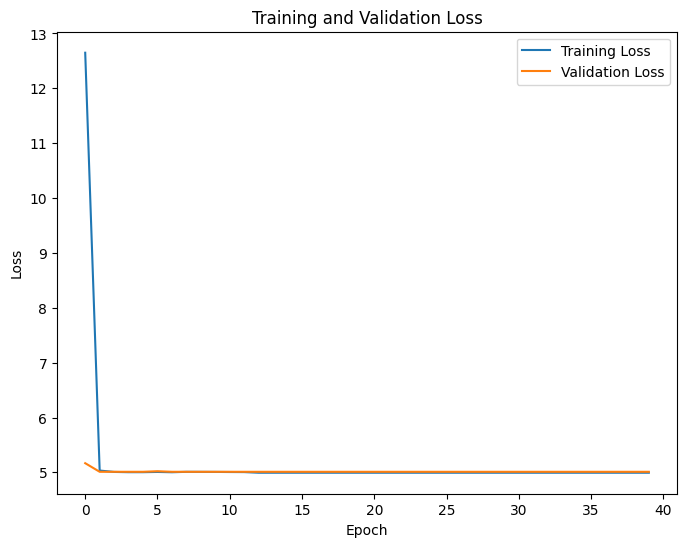

In [230]:
# 10. Plot Training/Validation Loss and Confusion Matrix
# =============================================================================
plt.figure(figsize=(8, 6))
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

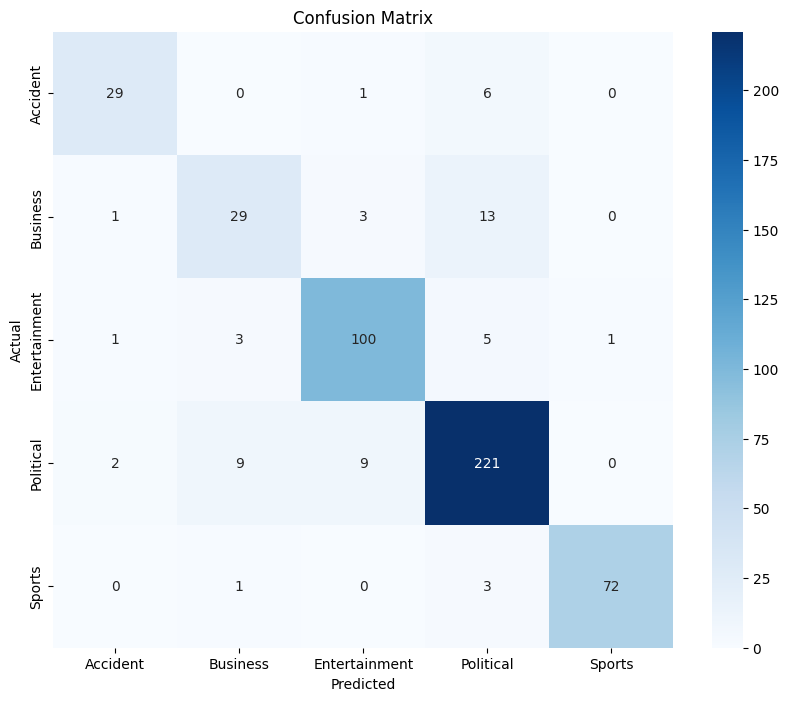

In [231]:
# Define class labels for better readability
label_mapping = {
    0: 'Accident',
    1: 'Business',
    3: 'Entertainment',
    6: 'Political',
    8: 'Sports'
}

# Replace numeric labels with string labels
xticks = [label_mapping.get(label, f'Class {label}') for label in sorted(news['label'].unique())]
yticks = [label_mapping.get(label, f'Class {label}') for label in sorted(news['label'].unique())]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=xticks,
            yticklabels=yticks)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Print the classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        25
           1       0.68      0.62      0.65        34
           3       0.84      0.90      0.87        73
           6       0.89      0.89      0.89       155
           8       0.98      0.94      0.96        53

    accuracy                           0.87       340
   macro avg       0.85      0.84      0.84       340
weighted avg       0.87      0.87      0.87       340

